<a href="https://colab.research.google.com/github/felipe-parodi/DL4DataScience/blob/main/Week12_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 12 Part 1
# Policy Gradient and Model-Based RL

__Instructor:__ Dinesh Jayaraman

__Content creators:__ Varun Velpula, Chuning Zhu

---

In [ ]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'fparodi' #@param {type:"string"}
my_pod = 'superfluous-lyrebird' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion']


## Recap the experience from last week

What did you learn last week. What questions do you have? [10 min discussion]

In [ ]:
learning_from_previous_week = "Learned about deep q learning, replay buffer, target network, and double q-learning. We also finished off with deep deterministic policy gradients. I BROADLY understand in theory, but  i'm  not sure how I would implement these models in practice." #@param {type:"string"}

---
# Setup

In [ ]:
#@markdown ## Install

!apt -q install imagemagick
!apt install -q xvfb
!pip install -q pyvirtualdisplay

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsf

In [ ]:
# imports
import numpy as np
import pandas as pd
import random
import sys
import time
from builtins import super
from collections import namedtuple
from __future__ import print_function
from pathlib import Path
from tqdm.auto import tqdm


# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable as V
from torch.distributions import Normal

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu") # CPU actually trains faster because there is no batch

# IPython
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython import display
from IPython.display import Image # display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Gym
import gym
import gym.spaces
gym.logger.set_level(gym.logger.ERROR)

# Gym rendering
from pyvirtualdisplay import Display

d = Display()
d.start();


In [ ]:
#@markdown ## Figure setting
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update(plt.rcParamsDefault)
plt.rc('animation', html='jshtml')

In [ ]:
#@markdown ## Seeds
seed = 1
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed);

In [ ]:
#@markdown ## Helper functions

def visualize(env, policy, ep_steps):
    # Simulate agent in environment
    frames = []
    state = env.reset()
    for s in range(ep_steps):
        action, _ = policy.get_action(state)
        next_state, _, done, _ = env.step(action)

        display.clear_output(wait=True)
        frames.append(env.render('rgb_array'))
        state = next_state
        if done:
            break
    
    # Generate video
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    animate = lambda i: patch.set_data(frames[i])
    anim = animation.FuncAnimation(plt.gcf(), animate, frames=range(len(frames)), interval=50)
    plt.close() # avoid showing extra plots
    return anim

---
# Overview


Video available at https://youtube.com/watch?v=Yx_7nSg979Q


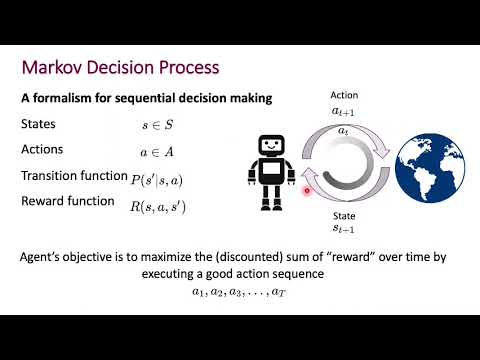

In [ ]:
#@title Video: Policy Gradient Introduction

import time
try: t0;
except NameError: t0=time.time()

from IPython.display import YouTubeVideo

video = YouTubeVideo(id="Yx_7nSg979Q", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

Last week, we learned our first deep reinforcement learning algorithm -- deep Q-learning. Deep Q-learning has its root in tabular Q-learning, where we estimate the value of each action at a state and take the action with the maximum value. As we have seen, deep Q-learning is powerful and can be leveraged to solve Atari games from high-dimensional observations. However, it has a few drawbacks: 

- The policy implied by Q-Learning is deterministic. This means that Q-Learning can’t learn stochastic policies, which can be useful in some environments. It also means we need to create our own exploration strategy since following the policy will not perform any exploration. We usually do this with $\epsilon$-greedy exploration which can be quite inefficient.
- There is no straightforward way to handle continuous actions in Q-Learning. We can go around this by having an additional actor network which predicts the argmax action. This leads to the DDPG algorithm.

Recall that the goal of reinforcement learning is to learn an optimal **policy**. Can we do that directly? In this tutorial, we will introduce another family of RL algorithms called policy gradient methods, which optimize the policy directly using gradients of the RL objective. Here are a few reasons why policy gradient can be desirable:


- In policy gradient, handling continous actions is relatively easy.
- As its name suggests, in policy gradient we are following gradients with respect to the policy itself, which means we are constantly improving the policy. By contrast, in Q-learning we are improving our estimates of the values of different actions, which only implicitly improves the policy. You would think that improving the policy directly would be more efficient, and indeed it very often is.

The main topic of this tutorial is policy gradient, covered in sections 1 through 3. In section 4, we will briefly go over another paradigm for solving reinforcement learning problems, namely model-based RL. 

---
# Section 1: Intuition of Policy Gradient

Before learning the canonical policy gradient algorithm, let's build our intuition of policy optimization. Let $\pi_{\theta}$ be  a policy parametrized by $\theta$, where $\pi_{\theta}(a|s)$ is the probability of taking an action $a$ in the current state $s$. Our goal is to iteratively update the parameters $\theta$ such that $\pi_{\theta}$ eventually becomes the optimal policy. In particular, we want to find an update rule from $\theta_t$ to $\theta_{t+1}$ that leads us to the optimal policy $\theta^*$.

For now, let's assume discrete actions, where the output of the policy network is a probability distribution over all actions. To generalize to continuous actions, we can have the network parametrize a Gaussian distribution, similar to the encoder of VAE. In either case, we sample an action from the distribution to execute in inference time.

In [ ]:
#@markdown ## Run me (helper function)
def simulate_policy_gradient(update_fn, filename, init=[0.0]*3):

    # a,b,c are widgets which contain four variables
    a = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.010)
    b = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.005)
    c = widgets.FloatSlider(min=0.0, max=1.0, value=1.0, step=0.0025)
    sliders = [a, b, c]
    
    # initialize the logit and q-value for each action
    for i, s in zip(init, sliders):
        s.logit = i
        s.q_val = s.step * 1000
    
    def update_values():
        exps = [np.exp(e.logit) for e in sliders]
        for ex, slid in zip(exps, sliders):
            slid.value = ex / np.sum(exps)
            slid.grad = slid.value * (1-slid.value)
            
    update_values()
    np.random.seed(1)
    it = 0
    animation_data = []
    while all([v.value < 0.95 for v in [a, b, c]]):
        incr_idx, incr_size = update_fn(sliders)
        update_values()
        it += 1
        animation_data.append((incr_idx, incr_size, [v.value for v in sliders]))
        
    if filename is not None:
        fig, ax = plt.subplots()

        def plot_animation(i):
            plt.clf()
            incr_idx, incr_size, values = animation_data[i]
            plt.bar(['Val = %s' % (v.step * 1000) for v in sliders], values, width=0.5)
            plt.ylim(0, 1.19)
            if incr_size > 0:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx] + incr_size + 0.05), xycoords='data',
                    xytext=(incr_idx, values[incr_idx]), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='green'),
                )
            else:
                plt.annotate('',
                    xy=(incr_idx, values[incr_idx]), xycoords='data',
                    xytext=(incr_idx, values[incr_idx] - incr_size + 0.05), textcoords='data',
                    arrowprops=dict(width=5, connectionstyle="arc3", color='red'),
                )
            return fig,

        ani = animation.FuncAnimation(fig, plot_animation, frames=list(range(0, len(animation_data))), blit=False)
        ani.save(filename, writer='imagemagick', fps=10)
        plt.close()
    
    print('Done in %s iterations' % it)

Let's look at a toy example to better understand how the policy optimization is done. In this toy example, there is a single state $s$ and three actions $a_1, a_2, a_3$. These actions have pre-defined Q-values `[10, 5, 2.5]`. We don't use a neural network yet, but assign a logit to each action. The policy is derived by taking the softmax of these logits. Our goal is to update the logits (which we denote $\theta$) using gradient method so that the policy becomes optimal. 


Let $a^*$ be the optimal action. We want $\pi_{\theta}(a^*|s)$ to approach 1. If we had known the optimal action $a^*$, we can update the logits of $a^*$ by **gradient ascent**:

$$
\theta_{t+1}=\theta_{t}+\alpha \nabla \pi_{\theta_{t}}\left(a^{*} | s\right)
$$

Run the following cells to visualize how the results would like if we had known the optimal action $a^* = a_1$. The height of each bar is the probability of taking each action, and the arrow shows the gradient that we are following in each iteration.

Done in 55 iterations


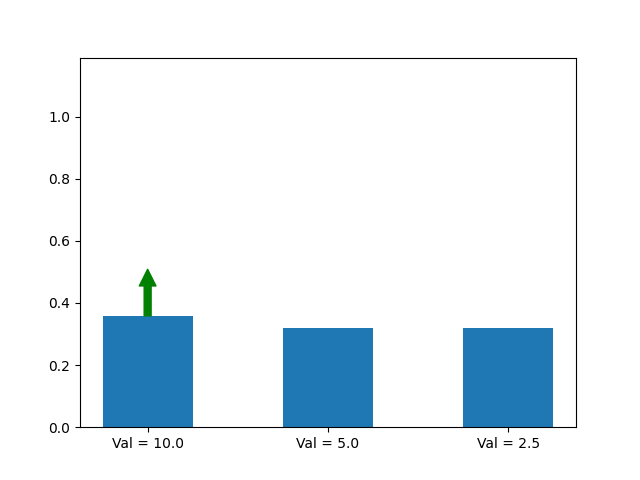

In [ ]:
#@title Known optimal action

lr = 0.5
def update_known_optimal(actions):
    # Each action has a .logit attribute that we must update. It also has a .grad attribute
    # that gives the gradient of the that action.
    actions[0].logit += lr * actions[0].grad
    # We return the index of the action we updated and the size of the arrow to draw
    # (which should be the size of our update, divided by a scaling factor to make the 
    # visual more appealing)
    return 0, lr / 5
    
simulate_policy_gradient(update_known_optimal, 'known_optimal.gif')
gifPath = Path("known_optimal.gif")
with open(gifPath,'rb') as f:
    Image(data=f.read(), format='png')

In practice, we do not know which actions are good. One solution would be to push on actions **proportional to our guess of the values** of these actions. These guesses can be highly approximate, but as long as they are somewhat grounded in reality, more overall pushing will happen on the optimal action $a^∗$. This way, it is guaranteed that our policy will converge to $\pi_{\theta}(a^∗|s)=1$.

In the following demo, we sample an action $a$ uniformly at random in each iteration of policy update. We cheat a little and construct our value estimates by adding noise to the true value. Let $\hat{Q} (s,a)$ denote our value estimate of action $a$, we apply the following update to the logits:

$$
\theta_{t+1}=\theta_{t}+\alpha \hat{Q}(s, a) \nabla \pi_{\theta_{t}}(a | s)
$$



Done in 58 iterations


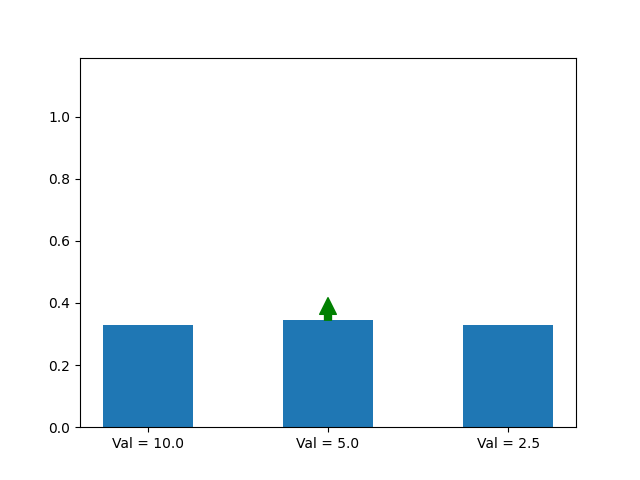

In [ ]:
#@title Random action selection

lr = 0.1
def update_q_value(actions):
    i = np.random.choice(list(range(len(actions))))
    value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * value_est * actions[i].grad
    return i, lr * value_est / 10
    
simulate_policy_gradient(update_q_value, 'random_action.gif')
gifPath = Path('random_action.gif')
with open(gifPath,'rb') as f:
    Image(data=f.read(), format='png')


Here we assumed that we are given the values for each action. But in reality we do not know the values before training. How is the value generally computed (recollect what you learned in W11)?

In [ ]:
value_estimate = "Run the policy several times and then average the rewards" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/value_estimate.md)

In practice, our agent is not going to choose actions uniformly. Rather, the actions are selected from the same policy $\pi_{\theta}$ that we are trying to learn. This is called **on-policy** training. There are two reasons why we might want to train on-policy:

- We accumulate more rewards even as we train, which is desirable in some contexts.
- It allows us to explore more promising areas of the state space by acting according to our current guess of the optimal actions.

Let’s illustrate this phenomenon by using the same update rule as above but sampling actions according to their probabilities given by the current policy.

Done in 122 iterations


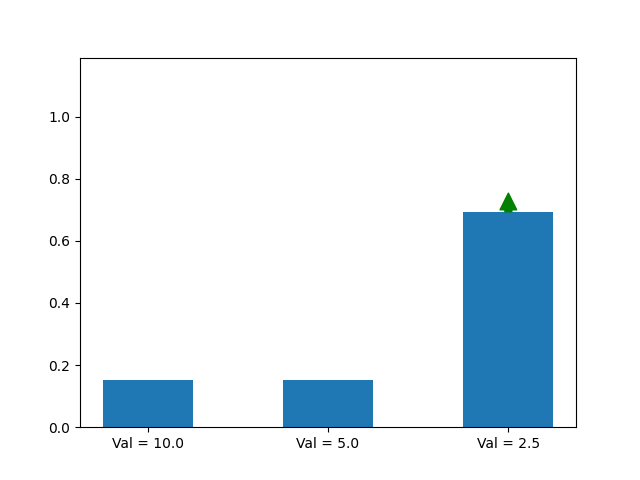

In [ ]:
#@title On-Policy gradient update

lr = 0.1
def update_q_value_bad(actions):
    # p decides the probability with each action is selected.
    # Initially they are equal, but as value corresponding to one action
    # becomes larger and larger, that action is selected more often
    i = np.random.choice(list(range(len(actions))),p=[e.value for e in actions])
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val
    actions[i].logit += lr * q_value_est * actions[i].grad
    return i, lr * q_value_est / 5

init_logits = [0., 0., 1.5] 
simulate_policy_gradient(update_q_value_bad, 'bad.gif', init_logits)
gifPath = Path('bad.gif')
with open(gifPath,'rb') as f:
    Image(data=f.read(), format='png')


In the above example we see that action 3 is selected despite action 1 being the better action. Why do you think so? Take a look at the `init_logits` in the above cell. For reference, the update rule is $\theta_{t+1}=\theta_{t}+\alpha \hat{Q}(s, a) \nabla \pi_{\theta_{t}}(a \mid s)$.

In [ ]:
bad_actions = "We push on actions with better values, including those that may be initialized with higher values (which may end up promoting bad actions)" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/bad_actions.md)

The above example shows that we need to compensate for the fact that more probable actions are going to be sampled more often. This leads us onto **on-policy correction**. The idea is to divide our update by the probability of the action. For example, if an action is 4x more likely to be taken than another, we will have 4x more gradient updates but each update would become 4x smaller. This is gives rise to the following update:

$$
\theta_{t+1}=\theta_{t}+\alpha \frac{\hat{Q}(s, a) \nabla \pi_{\theta_{t}}(a \mid s)}{\pi_{\theta_t}(a \mid s)}
$$

In this exercise, you will follow the instructions to fill in the gradient update rule for on-policy correction. 

### Exercise 1: On-policy Correction

Done in 30 iterations


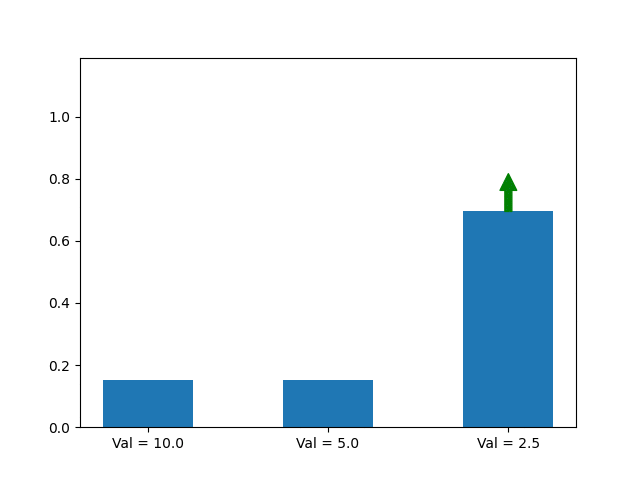

In [ ]:
lr = 0.1
def update_q_value_fixed(actions):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("Update Q value fixed")
    ####################################################################

    # p (policy) decides the probability with each action is selected. As the
    # probability of one action becomes larger, that action is selected more often.
    # The probability of an action is stored in actions[i].value
    num_actions = len(actions)
    probs = [e.value for e in actions]
    i = np.random.choice(list(range(num_actions)), p=probs)

    # Noise is added to simulate values we get in training which vary with every episode
    q_value_est = actions[i].q_val + np.random.randn() * actions[i].q_val

    # Complete the update rule. alpha is given by lr. The gradient and probabiliy 
    # of an action can be accessed via actions[i].grad and actions[i].value.
    actions[i].logit += lr*((q_value_est*actions[i].grad)/actions[i].value)

    return i, lr * q_value_est / actions[i].value 

# Uncomment on completion
simulate_policy_gradient(update_q_value_fixed, 'final_policy_grad.gif', init=[0.0, 0.0, 1.5])

gifPath = Path('final_policy_grad.gif')
with open(gifPath,'rb') as f:
    Image(data=f.read(), format='png')

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/W12_Tutorial1_Solution_Ex01.py)

---
# Section 2: REINFORCE

Video available at https://youtube.com/watch?v=jBRFiMWCCRI


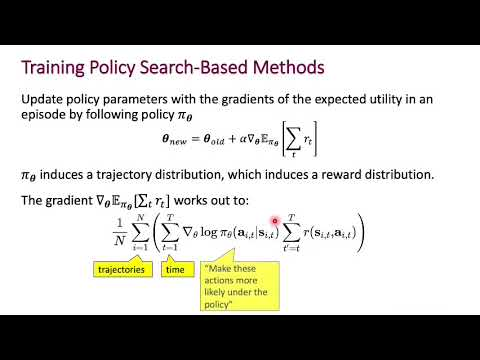

In [ ]:
#@title Video: The REINFORCE Algorithm

try: t1;
except NameError: t1=time.time()

video = YouTubeVideo(id="jBRFiMWCCRI", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 2.1: The REINFORCE algorithm

Now that we've built some intuition on policy gradient using the toy example, we proceed to derive policy gradient for real RL problems. Recall that the reinforcement learning objective is to maximize the expect cumulative reward. Omitting discount factors for now, the objective can be written as follows: 
$$ J(\theta) = E_{\pi_{\theta}}\left[\sum_{t=0}^{T}r(s_t, a_t)\right]$$ 

Can we directly differentiate $J(\theta)$ with respect to policy parameters $\theta$? This isn't straightforward because the objective involves an expectation. In the VAE tutorial, we've seen one way of estimating gradients through an expectation: the reparametrization trick. Here we will use another technique called score function estimator. The full derivation of policy gradient using the score function estimator can be found in the appendix, but for our purposes we only need to know that $\nabla_{\theta}J(\theta)$ takes the following form:


\begin{align*}
\nabla_{\theta}J(\theta) &= E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)\sum_{t=1}^{T}r(s_t, a_t)\right] \\
&\approx \frac{1}{N} \sum_{i=1}^{N} \left(\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)\sum_{t=1}^{T}r(s_t, a_t)\right)
\end{align*}

In the first expression above, $\tau = (s_1, a_1, \dots s_T, a_T)$ denotes a trajectory, and $p_{\theta}(\tau)$ is the distribution over trajectories induced by the policy. To estimate the policy gradient, we sample $N$ policy rollouts of $T$ steps each and compute the policy gradient using the second expression. This procedure is called **Monte-Carlo sampling**. Intuitively, we push up the log-probability of each action in proportion to the total obtained reward. In other words, we encourage actions seen in good trajectories and penalize those seen in bad trajectories.

The vanilla policy gradient can suffer from a high variance. The issue is intrinsic to the probabilistic nature of the objective and Monte-Carlo sampling. As we unroll the policy forward in time, any small perturbation can lead to vastly different trajectories. So the average gradient could be uninformative. We could even have confilcting gradients because the same state-action pair may appear in both good and bad trajectories. The variance of gradients is also sensitive to reward magnitude. To see this, interact with the following demo and adjust `reward_weight` to see its impact. `reward_weight` is a constant used to scale the rewards.




In [ ]:
#@markdown ## Demo: Variance

# Report magnitudes of variances with different reward weights.

from torch.distributions.multivariate_normal import MultivariateNormal 

reward_weight =  1e-6#@param {type:"number"}
act_dim = 2


class Env:
    def __init__(self, rew_wt):
        self.goal = torch.tensor([10.0, 10.0])
        self.rew_wt = rew_wt

    def reward(self, state):
        return - self.rew_wt * torch.sum((self.goal - state)**2)

    def step(self, state, action):
        next_state = state + action
        reward = self.reward(next_state)
        return next_state, reward


def policy(state, theta):
    mean = torch.sigmoid(state.T @ theta)
    dist = MultivariateNormal(mean, covariance_matrix=0.001*torch.eye(act_dim))
    action = dist.sample((1,))
    return dist, action.squeeze()


def demo_variance(rew_wt, N=50, T=50):
    # Sample N rollouts of T steps each
    env = Env(rew_wt)
    init_state = torch.zeros((2))
    theta = torch.zeros((act_dim, act_dim), requires_grad=True)
    grads = []
    for i in range(N):
        state = init_state.clone()
        log_likes, rewards = 0, 0
        for t in range (T):
            dist, action = policy(state, theta)
            state, reward = env.step(state, action)
            log_likes += dist.log_prob(action)
            rewards += reward
        J = log_likes * rewards
        J.backward()
        grad = theta.grad.clone()
        grads.append(grad)
    var_grads = torch.var(torch.stack(grads, 0), 0)
    print(f"Variance of gradients: \n{var_grads.numpy()}")
    
demo_variance(rew_wt=reward_weight)

Variance of gradients: 
[[191.18721 414.0312 ]
 [194.81279 422.11884]]


In [ ]:
#@markdown Report the variance magnitude (e.g. 10^8) at these reward scales: 1, 1e-3, 1e-6.

grad_vars = "1: 10^13,10^14; 1e-3: 10^7, 10^8; 1e-6: 10^2" #@param {type:"string"}

We will see more ways to address the high variance issue later in this tutorial. For now, we can use two simple tricks to reduce the variance:

1. Note that the action at time $t$ only influences future rewards. Instead of weighting gradients of all actions using the sum of the entire trajectory's rewards, we should weight them by the sum of future rewards (reward-to-go). 
2. We can discount future rewards to reduce the reward magnitude. This means we multiply the reward at time $t' \geq t$ by $\gamma^{t'-t}$.

Applying these tricks, the policy gradient becomes 
\begin{align*}
\nabla_{\theta}J(\theta) \approx E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)\sum_{t'=t}^{T}\gamma^{t'-t}r(s_{t'}, a_{t'})\right]
\end{align*}



where the discounted future reward term $\sum_{t'=t}^{T}\gamma^{t'-t}r(s_{t'}, a_{t'})$ is often referred to as $G_t$. This policy gradient gives rise to the canonical algorithm called **REINFORCE**. Yes, you read it right, the name of the algorithm is exactly the name of the problem it's trying to solve. The pseudocode for REINFORCE is provided as follows

Repeat:
> 1. Sample trajectories $\{\tau_i\}_{i=1}^N$ from the environment using the current policy. If $N=1$, then we update the policy at the end of each episode.
2. Compute policy gradient: $\nabla_{\theta}J(\theta) \approx \frac{1}{N} \sum_{i=1}^{N} \left(\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)G_t\right)$
3. Update policy: $\theta_{t+1} \leftarrow \theta_{t} + \alpha \nabla_{\theta} J(\theta)$

REINFORCE is an on-policy method. That is, in each iteration we must evaluate the gradient on new trajectories collected with the current policy. On-policy methods are expensive to train since they require large amounts of environment interactions. There are off-policy policy gradient methods which we will not introduce in this tutorial.

### Exercise 2 : Solving Cartpole

To understand the REINFORCE algorithm better, lets use it to solve the [CartPole](https://gym.openai.com/envs/CartPole-v0/) environment from OpenAI Gym. In CartPole, a pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pole starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. An episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center. 


In this exercise, you will implement the REINFORCE algorithm. In particular, you will need to complete the `get_action` method in the policy network, which samples an action from the current policy, as well as `update_policy`, which performs one gradient update of the policy.

In [ ]:
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=0)
        return x 

    def get_action(self, state):
        state = torch.from_numpy(state).to(device).float()
        probs = self.forward(state)

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        # raise NotImplementedError("REINFORCE Policy")
        ####################################################################

        # Sample an action from the policy. Hint: use np.random.choice()
        action = np.random.choice(self.num_actions, p=probs.cpu().detach().numpy()) # TODO

        # Compute log probabilty for this action
        log_prob = torch.log(probs[action]) # TODO
        return action, log_prob


def update_policy(policy_network, rewards, log_probs, gamma):
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # raise NotImplementedError("REINFORCE Update")
    ####################################################################

    discounted_rewards = []
    for t in range(len(rewards)):
        # At each step, we compute the sum of discounted future rewards
        Gt = 0  # Gt is the sum of discounted future rewards
        pow = 0 # pow keeps track of the power of discount factor gamma
        for r in rewards[t:]:
            # Compute discounted reward at the current time step
            # Note: rewards is a list consisting of reward in each step of episode
            Gt = Gt + gamma**pow*r # TODO
            pow = pow + 1
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)

    policy_gradients = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        # Multiply log_prob with Gt and append to list of gradients.
        # How can we have the optimizer perform gradient ASCENT?
        policy_gradients.append(-log_prob * Gt) # TODO
    
    # Perform one step of gradient update
    policy_network.optimizer.zero_grad()
    objective = torch.stack(policy_gradients).sum()
    objective.backward() # compute gradients
    policy_network.optimizer.step()

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/W12_Tutorial1_Solution_Ex02.py)

Run the following cell to test your code. Training should take about 3 minutes.

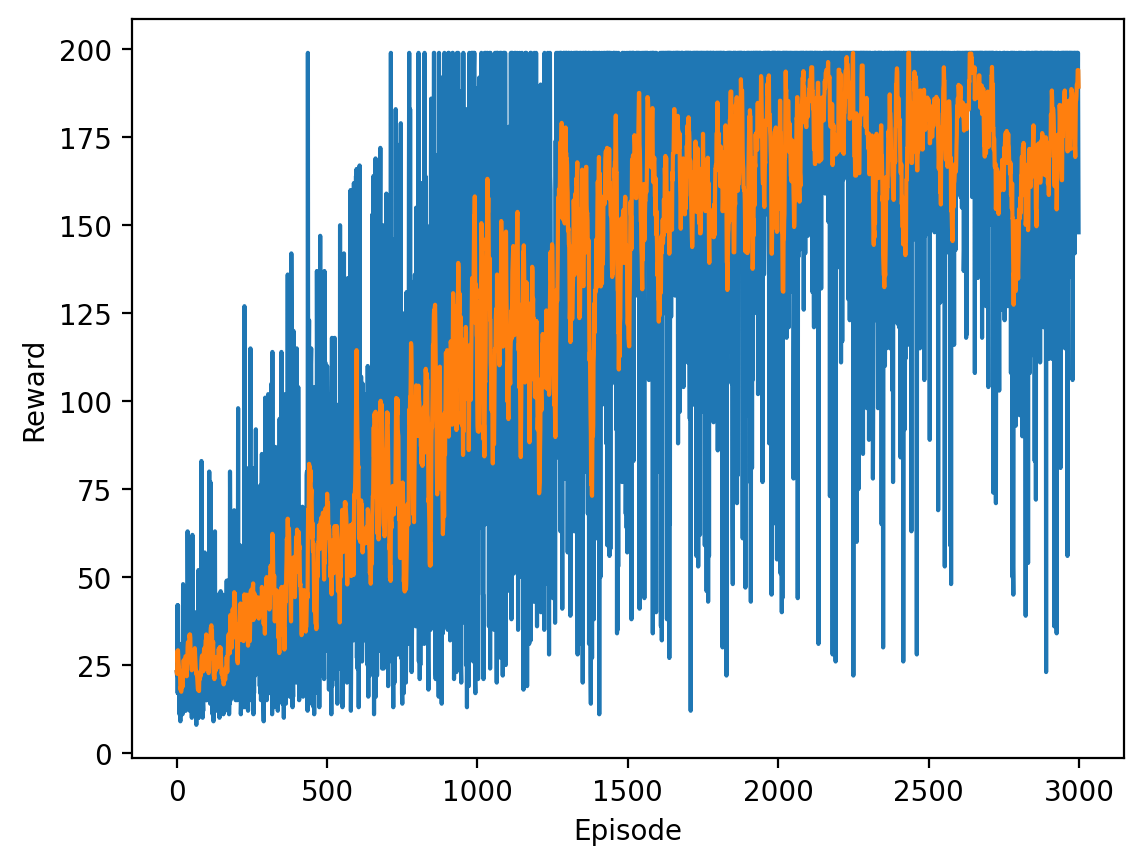

In [ ]:
# Reinforce algorithm
def reinforce(env, policy):
    max_episode_num = 3000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in tqdm(range(max_episode_num), position=0, leave=True):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            # Sample an action from the policy
            action, log_prob = policy_net.get_action(state)
            # Execute action in environment
            new_state, reward, done, _ = env.step(action)
            # Store log probability of action
            log_probs.append(log_prob)
            # Store reward
            rewards.append(reward)

            if done:
                # Train policy at the end of an episode
                update_policy(policy_net, rewards, log_probs, gamma=0.9)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                break
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.ylabel("Reward")
    plt.show()

env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
policy_net = policy_net.to(device)
reinforce(env, policy_net)

In [ ]:
# @markdown ## Run cell to generate video
visualize(env, policy_net, 200)

## Section 2.2: REINFORCE with whitening





From the above result, we see that it takes a lot of episodes for the model to stabilize at a reward of 200. Sometimes we may also see a sharp decrease of reward during training. To further tackle the high variance problem of the REINFORCE algorithm, we can subtract a baseline $b(s_t)$ from $G_t$ while calculating the policy gradient: 

\begin{align*}
\nabla_{\theta}J(\theta) &= E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)(G_t - b(s_t))\right]
\end{align*}

It can be shown that if the baseline only depends on $s_t$, then substracting the baseline still leads to an unbiased estimate of the policy gradient. See [this post](https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#baselines-in-policy-gradients) for more details. We will study a proper baseline in the next section, but there is a simple trick similar to a baseline which we can apply to greatly improve performance: we normalize the return at each step by the mean and standard deviation of all returns in the episode. This is called **whitening**. Whitening doesn't give us an unbiased estimator, but it works well in practice.

\begin{align*}
G_{t}^{*} &= \frac{G_{t}-\bar{G}}{\sigma_{G}} \\
\nabla_{\theta}J(\theta) &= E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)G_t^*\right]
\end{align*}

Rerun the below cell which implements a version of the REINFORCE algorithm with whitening.

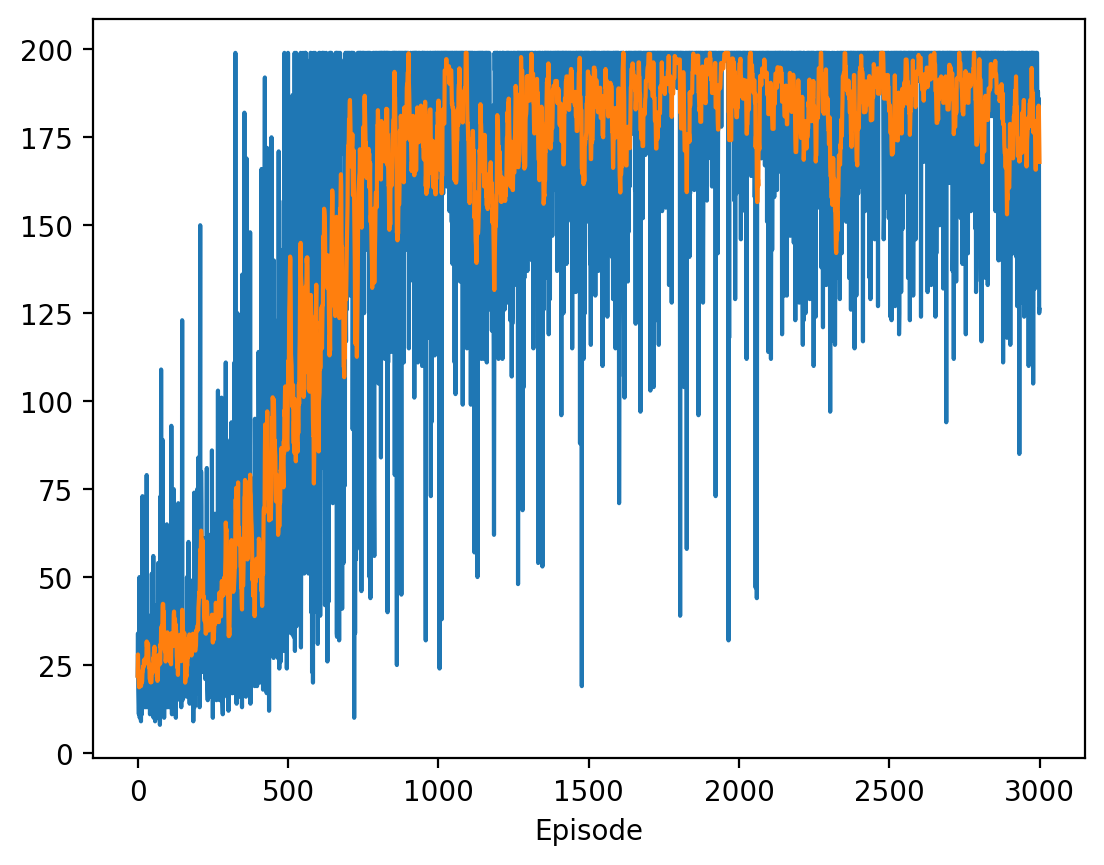

In [ ]:
#REINFORCE with whitening

class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=3e-4):
        super(PolicyNetwork, self).__init__()
        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.softmax(self.linear2(x), dim=1)
        return x 
    
    def get_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        probs = self.forward(state)
        action = np.random.choice(self.num_actions, p=np.squeeze(probs.detach().numpy()))
        log_prob = torch.log(probs.squeeze(0)[action])
        return action, log_prob

## Update
def update_policy(policy_network, rewards, log_probs, gamma):
    discounted_rewards = []
    for t in range(len(rewards)):
        Gt = 0 
        pow = 0
        for r in rewards[t:]:
            Gt = Gt + gamma**pow * r
            pow = pow + 1
        discounted_rewards.append(Gt)
    discounted_rewards = torch.tensor(discounted_rewards)
    # Add whitening
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradients = []
    for log_prob, Gt in zip(log_probs, discounted_rewards):
        policy_gradients.append(-log_prob * Gt)
    
    policy_network.optimizer.zero_grad()
    objective = torch.stack(policy_gradients).sum()
    objective.backward()
    policy_network.optimizer.step()

## Main loop
def reinforce_whitening(env, policy):
    
    max_episode_num = 3000
    max_steps = 10000
    numsteps = []
    avg_numsteps = []
    all_rewards = []

    for episode in tqdm(range(max_episode_num),position=0, leave=True):
        state = env.reset()
        log_probs = []
        rewards = []

        for steps in range(max_steps):
            action, log_prob = policy_net.get_action(state)
            new_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)

            if done:
                update_policy(policy_net, rewards, log_probs, 0.9)
                numsteps.append(steps)
                avg_numsteps.append(np.mean(numsteps[-10:]))
                all_rewards.append(np.sum(rewards))
                break
            state = new_state
        
    plt.plot(numsteps)
    plt.plot(avg_numsteps)
    plt.xlabel('Episode')
    plt.show()

env = gym.make('CartPole-v0')
policy_net = PolicyNetwork(env.observation_space.shape[0], env.action_space.n, 128)
policy_net = policy_net.to(device)
reinforce_whitening(env, policy_net)

In [ ]:
#@markdown ## Run cell to generate video
visualize(env, policy_net, 200)

In [ ]:
#@markdown What is the intuition behind whitening of expected rewards for reducing the variance between episodes?
whitening_intuition = "whitening reduces variance leading to smaller updates" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/whitening_intuition.md)

---
# Section 3: Actor-Critic Algorithm

Video available at https://youtube.com/watch?v=O8OEs5CfgYs


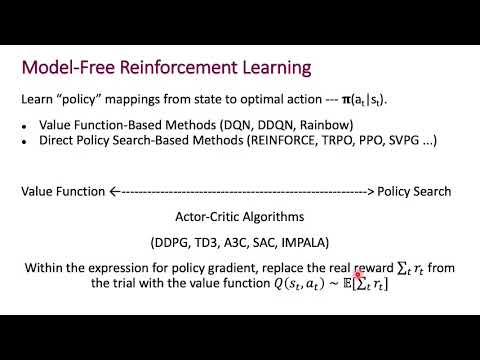

In [ ]:
#@title Video: Actor-Critic Training

try: t2;
except NameError: t2=time.time()

video = YouTubeVideo(id="O8OEs5CfgYs", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

At the end of the last section, we breifly mentioned reducing the variance of policy gradient by subtracting a baseline from the discounted future reward at each step. What is a good candidate for the baseline? Is there a quantity that measures how good a state is **on average**? You may have guessed it: the value function! Indeed, a common choice of baseline is the value function $V(s)$, in which case the policy gradient becomes 

\begin{align*}
\nabla_{\theta}J(\theta) &= E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)(G_t - V(s_t))\right]
\end{align*}

Here, the policy can be thought of as an actor, and the value function can be considered a critic that evaluates how good each action is. This is why we call it an **actor-critic algorithm**. During training, we alternately update the actor with policy gradient and the critic by minimizing the MSE between its prediction and the sum of discounted future rewards.

Let's take a closer look at the expression. Recall that the value function essentially tells us how good a state is, averaged across all actions. So intuitively we encourage actions that do better than average, and penalize those that do worse. This algorithm is also called the **advantage actor critic (A2C)** because $G_t - V(s_t)$ approximates the advantage function of a state-ation pair defined as $$A(s_t, a_t) = Q(s_t, a_t) - V(s_t)$$

From an advantage function point of view, we are approximating the Q-value of $s$ and $a$ using the discounted future reward of the current trajectory. To stablize training, we can further bootstrap an estimate of the Q-value from the value function (critic). Instead of executing all the way to termination, we rollout $n$-steps and compute $$Q(s_t, a_t) = \sum_{t'=t}^{t+n-1}\gamma^{t'-t}r(s_{t'}, a_{t'}) + \gamma^{n}V(s_{t+n})$$

That is, we take $n-1$ real rewards and bootstrap an expected sum of future rewards from the value function. This relates back to TD learning introduced in week 11. In particular, if $n=1$, then the advantage function is approximated by the TD error: $A(s,a) = r + \gamma V(s') - V(s)$. We present an analysis of the actor-critic algorithm from a TD perspective in the appendix. 



## Exercise 3: Advantage actor-critic

In the following exercise, you will implement the advantage actor-critic algorithm. Complete the main `a2c` function and train an actor-critic agent to solve the CartPole environment. Training should take about 7 minutes.

In [ ]:
# Actor network
class Actor(nn.Module):
    def __init__(self, state_dim, num_actions, learning_rate=1e-3):
        super().__init__()
        self.num_actions = num_actions
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 32),
            nn.Tanh(),
            nn.Linear(32, num_actions),
            nn.Softmax(0)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state):
        return self.model(state)

    def get_action(self, state):
        state = torch.from_numpy(state).to(device).float()
        probs = self.forward(state)
        # Sample an action from the policy.
        action = np.random.choice(self.num_actions, p=probs.cpu().detach().numpy())
        # Compute log probabilty for this action
        log_prob = torch.log(probs[action])
        return action, log_prob

# Critic network
class Critic(nn.Module):
    def __init__(self, state_dim, learning_rate=1e-3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state):
        return self.model(state)

    def get_value(self, state):
        return self.forward(torch.from_numpy(state).to(device).float())[0]

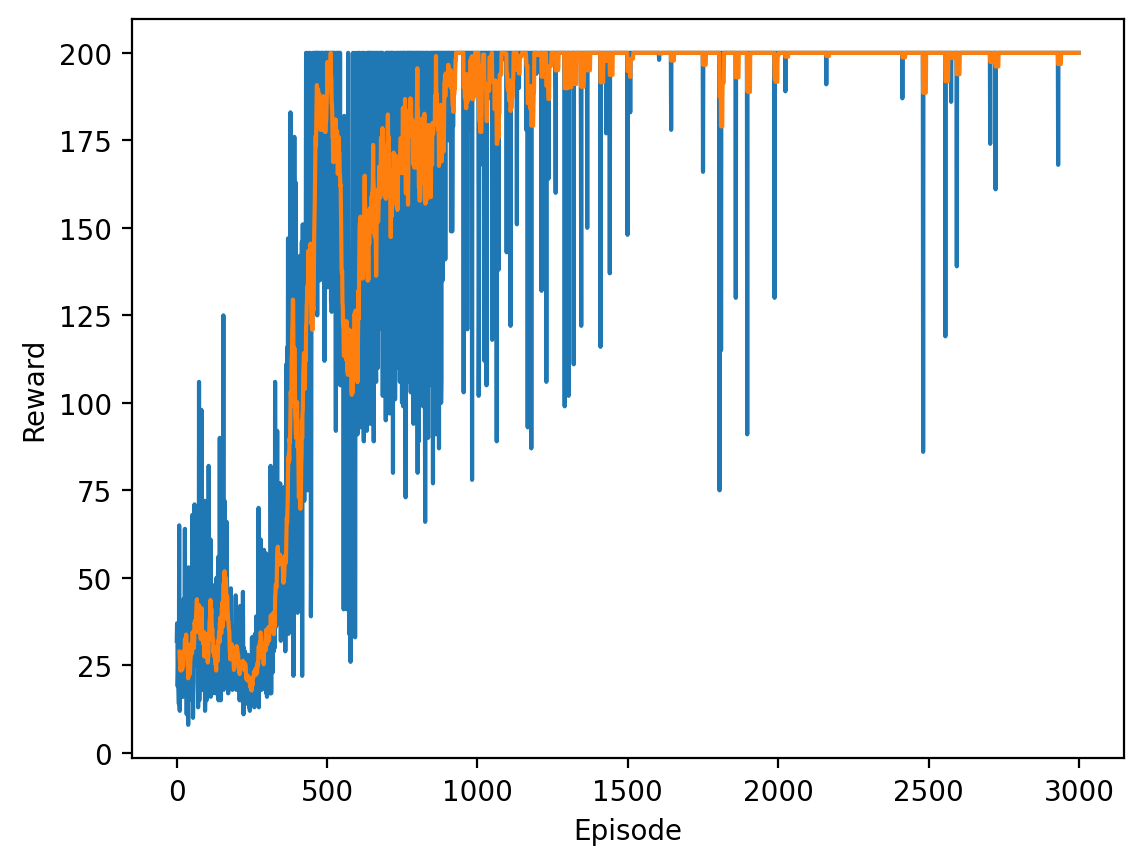

In [ ]:
def a2c(env, actor, critic, max_episodes, num_steps, gamma=0.99):
    all_lengths = []
    average_lengths = []
    all_rewards = []

    for episode in tqdm(range(max_episodes), position=0, leave=True):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            # Get the value of the current state from the critic
            value = critic.get_value(state)

            # Get an action and its log probability from the actor
            action, log_prob = actor.get_action(state)

            # Execute action in environment 
            new_state, reward, done, _ = env.step(action)

            # Store value, log probability, and reward
            values.append(value)
            log_probs.append(log_prob)
            rewards.append(reward)

            # Update state
            state = new_state
            
            if done or steps == num_steps - 1:
                # Store value of the last state
                V_last = critic.get_value(new_state)
                all_rewards.append(np.sum(rewards))
                break
        
        
        values = torch.stack(values)
        log_probs = torch.stack(log_probs)

        # Compute Q values. Qvals[t] = r_t + gamma * r_{t+1} + ... + gamma^{T-t} * v_T
        Qvals = torch.zeros_like(values)
        # At this point, V_last stores the value of the last state, which we bootstrap from.
        Qval = V_last
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + gamma * Qval
            Qvals[t] = Qval
        
        
        # Compute advantage for all steps
        advantage = Qvals - values

        # Update critic
        critic_loss = advantage.pow(2).mean()
        critic.optimizer.zero_grad()
        critic_loss.backward()
        critic.optimizer.step()
        
        # Update critic
        actor_loss = torch.mean(-log_probs * advantage.detach())
        actor.optimizer.zero_grad()
        actor_loss.backward()
        actor.optimizer.step()

    # Plot results
    smoothed_rewards = pd.Series.rolling(pd.Series(all_rewards), 10).mean()
    smoothed_rewards = [elem for elem in smoothed_rewards]
    plt.plot(all_rewards)
    plt.plot(smoothed_rewards)
    plt.plot()
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

# Uncomment on completion
# Environment
env = gym.make("CartPole-v0")
state_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
# Actor and critic models
actor = Actor(state_dim, n_actions).to(device)
critic = Critic(state_dim).to(device)
# Hyperparameters
max_episodes = 3000
num_steps = 300
a2c(env, actor, critic, max_episodes, num_steps)

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/W12_Tutorial1_Solution_Ex03.py)

In [ ]:
# @markdown ## Run cell to generate video
visualize(env, actor, 200)

Video available at https://youtube.com/watch?v=m_bU6gb9W4M


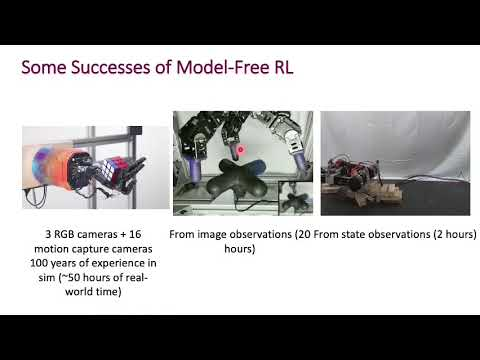

In [ ]:
#@title Video: Model-Free RL Examples

video = YouTubeVideo(id="m_bU6gb9W4M", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Section 4: Model-Based Reinforcement Learning

Video available at https://youtube.com/watch?v=54q4Wf7anmc


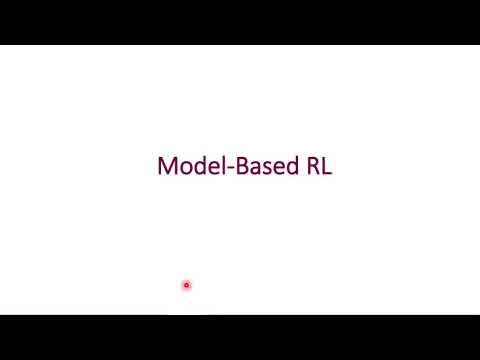

In [ ]:
#@title Video: Model-Based RL Intro

try: t3;
except NameError: t3=time.time()

video = YouTubeVideo(id="54q4Wf7anmc", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

One issue with RL algorthms we've seen so far is bad sampling efficiency. Both DQN and policy gradient require huge amounts of environment interactions to be effective. This makes it difficult to apply reinforcement learning to problems where data colloection can be slow or expensive. Sampling efficiency can be greatly improved if we have an internal representation of the environment from which we can obtain additional data. This technique is called model-based reinforcement learning (MBRL). In MBRL, we learn a model of the transition dynamics (and sometimes the reward function) of the environment. The simplist model is a neural network $f_{\theta}$ which predicts the next state give the current state and action: $s_{t+1} = f_{\theta}(s_t, a_t)$. Having a model opens up many possibilities. Broadly speaking, we can either augment policy DQN / gradient with experience sampled from the model, or apply planning techniques to find the optimal action.

Besides good sampling efficiency, another motivation for MBRL is fast adaptation. Consider a task where a robotic arm needs to reach a goal. We can easily train the agent to reach a fixed goal, but what if we want it to reach another goal? Model-free RL techniques would have to learn everything from scratch again. However, note that when the goal changes, the underlying physics doesn't. Thus, using MBRL, we can keep the dynamics model and only adapt the reward model to the new goal, enabling the agent to quickly solve the new task.

In [ ]:
#@markdown If we add an obstacle to the goal-reaching task, do we need to retrain the dynamics model? Why?
obstacle = "yes the model wouldn't knwo what to do" #@param {type:"string"}

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/obstacle.md)

Video available at https://youtube.com/watch?v=MmF8dYifZDY


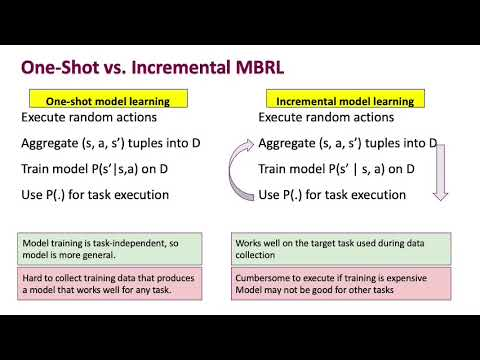

In [ ]:
#@title Video: Model Learning and Usage

video = YouTubeVideo(id="MmF8dYifZDY", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

## Section 4.1: Planning with world models

We will not go into details of model-based policy optimization or Q-learning. Instead, we will dedicate this section to introducing some planning techniques that can be used to directly find the optimal action given a learned model. Given a model, here are a few things we can do:


1. If the state space is small, we can apply dynamic programming techniques like policy/value iteration to find an optimal policy. Recall that policy/value iteration assumes full knowledge of the dynamics and rewards, which the model approximates.
2. If the state space is large, we can consider an approach introduced all the way back in week 1: Monte-Carlo tree search. Note that AlphaZero is not model-based. We use MCTS because we know the transitions of an Chess game.
3. The previous cases assume discrete actions. With a continuous action space, we resort to trajectory optimization techniques. 


Let's take a look at a sampling-based trajectory optimization technique called the cross-entropy (CE) method. Say we are currently at state $s$. Our goal is to find a sequence of actions $a_1, \dots a_H$ that maximize the reward. $H$ is the horizon of the plan. To do this, let's try modeling the action squence using an isotropic gaussian distribution, with means $\mu_1, \dots, \mu_H$ and standard deviations $\sigma_1, \dots \sigma_H$. We want to update this distribution to eventually sample a good sequence from it. To do this, we initialize the distribution to unit gaussian and repeat the following process:
```
Repeat for s steps:
    Sample n action sequences from the current distribution.
    Roll out the sequences through our model (starting at s) and compute the reward for each trajectory.
    Re-fit our distribution to the top k action sequences. We do this by updating the means and stds to the means and stds of these k samples.
```
Finally, we sample an action sequence from the final distribution and execute the plan. In practice, the model is not perfect, and its prediction error will compound as we roll out many steps. Thus we typically execute only the first action from the sampled sequence and replan. This is called model-predictive control (MPC).

The following code is a demo for the CE method. We created a toy environment where a point is initialized at (0, 0) and needs to reach (10, 10). The actions are offsets in the x and y directions, and they are clipped to be within (-1, -1) and (1, 1). We use the environment itself as a perfect model and apply the CE method to plan from the initial state. 



In [ ]:
# Define action dimension
act_dim = 2

class PointEnv:
    def __init__(self):
        self.goal = torch.tensor([10.0, 10.0])
        self.init_state = torch.tensor([0., 0.])

    def reward(self, state):
        return - 0.1 * torch.sum((self.goal - state)**2, dim=-1)

    def step(self, state, action):
        next_state = state + torch.clip(action, -1, 1)
        reward = self.reward(next_state)
        return next_state, reward

    def unroll(self, state, actions):
        num_samples, horizon = actions.shape[0:2]
        states = state.unsqueeze(0).repeat(num_samples, 1)
        rewards_total = torch.zeros(num_samples)
        for t in range(horizon):
            next_states, rewards = self.step(states, actions[:, t])
            states = next_states
            rewards_total += rewards
        return rewards_total

# CEM on point environment with known transitions and reward
def cross_entropy_method(model, state, horizon, n=100, k=10, num_iters=10):
    act_mean = torch.zeros((horizon, act_dim))
    act_std = torch.ones((horizon, act_dim))
    for i in range(num_iters):
        # Create distribution using mean and std
        act_dist = Normal(act_mean, act_std)
        # Sample n action sequences
        actions = act_dist.sample([n])
        # Unroll squences through model and compute rewards
        rewards = model.unroll(state, actions)
        # Take the top k samples
        top_rews, top_inds = torch.topk(rewards, k)
        top_actions = actions[top_inds]
        # Re-fit distribution
        act_std, act_mean = torch.std_mean(top_actions, dim=0)
    return act_mean, act_std

# Use the environment as a perfect model
model = PointEnv()
init_state = model.init_state
act_mean, act_std = cross_entropy_method(model, init_state, horizon=10)
print(f"Mean of actions:\n{act_mean.numpy()}\nStd of actions:\n{act_std.numpy()}")

In [ ]:
#@markdown ## Run cell to execute an action sequence sampled from the planned distribution.

# Sample an action sequence from action distribution and execute all of them
# Our environment clips actions to within (-1, 1) so if all actions in our 
# sequence are greater than (1, 1) then we will reach the goal in 10 steps.
def execute_cem(env, init_state, act_mean, act_std):
    state = init_state
    act_dist = Normal(act_mean, act_std)
    actions = act_dist.sample()
    for act in actions:
        next_state, reward = env.step(state, act)
        diff = next_state - state
        plt.arrow(state[0], state[1], diff[0], diff[1], length_includes_head=True, head_width=0.15)
        state = next_state
    
    dist = torch.sum((state - env.goal)**2)
    print(f"Final distance to goal: {dist}")

    plt.scatter(init_state[0], init_state[1])
    plt.scatter(env.goal[0], env.goal[1])
    plt.show()

execute_cem(model, init_state, act_mean, act_std)

## Section 4.2: Approximating dynamics with a world model
Model learning is in theory off-policy, meaning it can learn from any data. However, in practice MBRL will perform poorly if we don't train the model with on-policy data. This makes sense because the model has limited capacity and we want it be accurate on parts of the state space that we care about. Below is a sketch of an MBRL algorithm with on-policy data collection.

```
Run base policy (e.g. random policy) to collect a dataset D of transition tuples.
Repeat
    Train model using samples from D.
    If there is a policy, update it with trajectories sampled from the model.
    Collect new data from the environment by executing the policy or planning from the model. Add new data to D.
```


We will not implement a full MBRL algorithm in this tutorial. Instead, you will train a dynamics model for the CartPole environment on randomly collected data. This will look a lot like supervised learning. The only caveat is that you will train the model to predict the state difference $\Delta s = s_{t+1} - s_{t}$, which is easier to learn when $s_t$ and $s_{t+1}$ are very similar. The next state can be reconstructed by adding the difference to the current state. Follow the instructions to fill in the `update` and `predict` methods of the dynamics model.

### Exercise 4: Train a dynamics model

In [ ]:
class DynamicsModel(nn.Module):
    def __init__(self, act_dim, state_dim, hidden_size, learning_rate=0.001):
        super().__init__()
        self.act_dim = act_dim
        self.state_dim = state_dim
        self.learning_rate = learning_rate
        
        # 2-layer fully connected network
        self.layers = nn.Sequential(
            nn.Linear(act_dim + state_dim, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, state_dim)
        )

        # Use Adam optimizer and MSELoss()
        self.optimizer = optim.Adam(self.layers.parameters(), self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def forward(self, input):
        return self.layers(input)

    def update(self, state, action, next_state):
        # Update model
        # state: [n, state_dim]
        # action: [n, act_dim]
        # next_state: [n, state_dim]

        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Model update")
        ####################################################################

        # Concatenate state and action along the last dimension
        input = ...

        # Forward input through model to get the output
        output = ...

        # Constuct target as the state difference 
        target = ...

        # Compute model loss using self.criterion
        loss = ...

        # Take one gradient step using self.optimizer
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def predict(self, state, action):
        ####################################################################
        # Fill in missing code below (...),
        # then remove or comment the line below to test your function
        raise NotImplementedError("Model predict")
        ####################################################################

        # Concatenate state and action along the last dimension
        input = ...

        with torch.no_grad():
            # Forward input through model to get the state difference
            diff = ...
            
        # Add difference to input state to reconstruct the next state.
        next_state = ...
        return next_state

[*Click for solution*](https://github.com/CIS-522/course-content/blob/main/tutorials/W12_DeepRL/solutions/W12_Tutorial1_Solution_Ex04.py)

In [ ]:
#@markdown ## Run cell to train model

class ReplayBuffer:
  def __init__(self, state_dim, act_dim, buffer_size):
    self.buffer_size = buffer_size
    self.ptr = 0
    self.n_samples = 0

    self.state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)
    self.action = torch.zeros(buffer_size, act_dim, dtype=torch.int64, device=device)
    self.reward = torch.zeros(buffer_size, 1, dtype=torch.float32, device=device)
    self.next_state = torch.zeros(buffer_size, *state_dim, dtype=torch.float32, device=device)

  def add(self, state, action, reward, next_state):
    self.state[self.ptr] = torch.tensor(state)
    self.action[self.ptr] = torch.tensor(action)
    self.reward[self.ptr] = torch.tensor(reward)
    self.next_state[self.ptr] = torch.tensor(next_state)
    
    if self.n_samples < self.buffer_size:
      self.n_samples += 1

    self.ptr = (self.ptr + 1) % self.buffer_size

  def sample(self, batch_size):      
    # Select batch_size number of sample indicies at random from the buffer
    idx = np.random.choice(self.n_samples, batch_size)    
    # Using the random indices, assign the corresponding state, action, reward,
    # and next state samples.
    state = self.state[idx]
    action = self.action[idx]
    reward = self.reward[idx]
    next_state = self.next_state[idx]
    return state, action, reward, next_state

def collect_random_data(env, num_samples=10000):
    print('Collecting random data')
    replay_buffer = ReplayBuffer(state_dim=(4,), act_dim=1, buffer_size=num_samples)
    state = env.reset()
    while replay_buffer.n_samples < replay_buffer.buffer_size:
        # Sample a random action
        action = env.action_space.sample()
        # Execute action in environment
        next_state, reward, done, info = env.step(action)
        # Add to replay buffer
        replay_buffer.add(state, action, reward, next_state)
        # Update state
        state = next_state
        if done:
            state = env.reset()
    return replay_buffer


def train_model(model, replay_buffer, num_iters, batch_size):
    print('Training model on collected data')
    losses = []
    for i in tqdm(range(num_iters)):
        # Sample batch from replay buffer
        states, actions, rewards, next_states = replay_buffer.sample(batch_size)
        # Update model
        loss = model.update(states, actions, next_states)
        losses.append(loss)

    # Show loss plot
    plt.plot(losses)
    plt.title('Dynamics loss')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()
    

def eval_model(model, env):
    # Show prediction errors
    state = env.reset()
    for i in range(5):
        action = env.action_space.sample()
        next_state, _, _, _ = env.step(action)
        state_t = torch.tensor(state, dtype=torch.float32, device=device)
        action_t = torch.tensor([action], dtype=torch.float32, device=device)
        next_state_pred = model.predict(state_t, action_t).cpu().numpy()
        error = next_state - next_state_pred
        print(f'Step {i}, prediction error: {error}')
        state = next_state

env = gym.make('CartPole-v0')
replay_buffer = collect_random_data(env)
model = DynamicsModel(act_dim=1, state_dim=4, hidden_size=10).to(device)
train_model(model, replay_buffer, num_iters=1000, batch_size=50)
eval_model(model, env)

In [ ]:
#@title Video: Model-Based RL Examples

try: t4;
except NameError: t4=time.time()

video = YouTubeVideo(id="ejouP7Qv3AA", width=854, height=480, fs=1)
print("Video available at https://youtube.com/watch?v=" + video.id)

video

---
# Wrap-up

In [ ]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame

#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src


#autofill time if it is not present
try: t0;
except NameError: t0 = time.time()
try: t1;
except NameError: t1 = time.time()
try: t2;
except NameError: t2 = time.time()
try: t3;
except NameError: t3 = time.time()
try: t4;
except NameError: t4 = time.time()
try: t5;
except NameError: t5 = time.time()


#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""
try: my_pod;
except NameError: my_pod = "Select"
try: learning_from_previous_week;
except NameError: learning_from_previous_week = ""
try: value_estimate;
except NameError: value_estimate = ""
try: bad_actions;
except NameError: bad_actions = ""
try: grad_vars;
except NameError: grad_vars = ""
try: whitening_intuition;
except NameError: whitening_intuition = ""
try: obstacle;
except NameError: obstacle = ""

times = np.array([t1,t2,t3,t4,t5])-t0

fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "learning_from_previous_week": learning_from_previous_week,
          "value_estimate": value_estimate,
          "bad_actions": bad_actions,
          "grad_vars": grad_vars,
          "whitening_intuition": whitening_intuition,
          "obstacle": obstacle,
          "cumulative_times": times}

src = "https://airtable.com/embed/shrflf6o9fqfsZhO9?"


# now instead of the original source url, we do: src = prefill_form(src, fields)
display.display(IFrame(src = prefill_form(src, fields), width = 800, height = 400));

## Feedback
How could this session have been better? How happy are you in your group? How do you feel right now?

Feel free to use the embeded form below or use this link:
<a target="_blank" rel="noopener noreferrer" href="https://airtable.com/shrNSJ5ECXhNhsYss">https://airtable.com/shrNSJ5ECXhNhsYss</a>

In [ ]:
display.display(IFrame(src="https://airtable.com/embed/shrNSJ5ECXhNhsYss?backgroundColor=red", width = 800, height = 400))

---
# Appendix

## A.1 Derivation of Policy Gradient

A typical reinforcement learning problem can be formulated as finding the optimial policy $\pi^*$ that maximizes the expected reward. Consider a class of parametrized policy $\{\pi_{\theta}\}$. (If we use neural nets to approximate the policy, then $\theta$ are the weights.) We can formalize the problem as
\begin{align*}
\theta^* &= \underset{\theta}{\operatorname{argmax}} J(\theta) \\
J(\theta) &= E_{\tau \sim p_{\theta}(\tau)}\left[r(\tau)\right]  
= \int p_{\theta}(\tau) r(\tau)d\tau
\end{align*}
<!-- \begin{align*}
&= \int \underbrace{p(s_1)\prod_{t=1}^{T}\pi_{\theta}(a_t|s_t)p(s_{t+1}|s_{t}, a_{t})}_{p_{\theta}(\tau)} \underbrace{\sum_{t=1}^{T}r(s_t, a_t)}_{r(\tau)}
\end{align*} -->

In the objective, $\tau$ denotes a trajectory, i.e. a sequence of state-action pairs $\tau = (s_1, a_1), \dots (s_T, a_T)$，where $T$ is commonly referred to as the horizon. $r(\tau)$ is the reward of $\tau$. $p_{\theta}(\tau)$ is the likelihood of $\tau$ under the policy $\pi_{\theta}$.
\begin{align*}
r(\tau) &= \sum_{t=1}^{T}r(s_t, a_t) \\
p_{\theta}(\tau) &= p(s_1)\prod_{t=1}^{T}\pi_{\theta}(a_t|s_t)p(s_{t+1}|s_{t}, a_{t})
\end{align*} 

To optimize the objective, we can try directly differentiating $J(\theta)$ with respect to $\theta$ and apply gradient ascent. 
\begin{align*}
\nabla_{\theta} J(\theta) = \nabla_{\theta} \int p_{\theta}(\tau) r(\tau)d\tau = \int \nabla_{\theta}(p_{\theta}(\tau))r(\tau)
\end{align*}
However, the gradient is intractable because $p_{\theta}(\tau)$ involves the transition probability $p(s_{t+1}|s_t, a_t)$ which is unknown to us. We can instead apply the following convenient identity to get rid of the transition probability:
\begin{align*}
\nabla_{\theta}(p_{\theta}(\tau)) = p_{\theta}(\tau)\frac{\nabla_{\theta}(p_{\theta}(\tau))}{p_{\theta}(\tau)} = p_{\theta}(\tau)\nabla_{\theta}\log p_{\theta}(\tau)
\end{align*}
Let's plug it back into $\nabla_{\theta}J(\theta)$ and see what happens. 

\begin{align*}
\nabla_{\theta}J(\theta) &= \int \nabla_{\theta}(p_{\theta}(\tau))r(\tau) \\
&= \int p_{\theta}(\tau)\nabla_{\theta}\log p_{\theta}(\tau)r(\tau) \\
&= E_{\tau \sim p_{\theta}(\tau)} \left[\nabla_{\theta}\log p_{\theta}(\tau)r(\tau)\right]
\end{align*}

Expanding the log gradient term, we get 
\begin{align*}
    \nabla_{\theta}\log p_{\theta}(\tau) &= \nabla_{\theta}\log \left(p(s_1)\prod_{t=1}^{T}\pi_{\theta}(a_t|s_t)p(s_{t+1}|s_{t}, a_{t})\right) \\
    &=\underbrace{\nabla_{\theta}\log p(s_1)}_{0} + \sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t) + \underbrace{\nabla_{\theta}\log p(s_{t+1}|s_{t}, a_{t})}_{0} \\
    &= \sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)
\end{align*}
Viola! Using the log gradient identity, we managed to get rid of the transition probabilities! Now the policy gradient becomes 
\begin{align*}
\nabla_{\theta}J(\theta) &= E_{\tau \sim p_{\theta}(\tau)} \left[\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)\sum_{t=1}^{T}r(s_t, a_t)\right] \\
&\approx \frac{1}{N} \sum_{i=1}^{N} \left(\sum_{t=1}^{T}\nabla_{\theta}\log\pi_{\theta}(a_t|s_t)\sum_{t=1}^{T}r(s_t, a_t)\right)
\end{align*}

The expectation can be evaluated via Monte-Carlo sampling, which is just a fancy way to say "take the average of many samples." How do we evaluate the $\log\pi_{\theta}(a_t|s_t)$ term? If the action space is discrete, then we can interpret the output of the neural network as the logits of actions and obtain the probabilities by taking the softmax. If the action space is continuous, then we can parametrize the policy using a standard probability distribution (e.g. Gaussian) which will naturally give us the probability of an action.

To get some intuition, let's look more closely at the policy gradient in it's simplified form. $$\nabla_{\theta}J(\theta) \approx \frac{1}{N}\sum_{i=1}^N\nabla_{\theta}\log\pi_{\theta}(\tau_i)r(\tau_i)$$ Note that we are essentially weighting the gradient of each trajectory proportionally to its reward. If a trajectory $\tau$ has a high reward, then we increase the likelihood of the actions seen in $\tau$. Otherwise we decrease the likelihood of those actions. It may seem imprudent to say that all actions in a high-reward trajectory are good, but in expectation this update converges to the optimal policy.

## A.2 Actor-critic from a TD perspective. 

Actor-critic methods are TD methods that have a separate memory structure to explicitly represent the policy independent of the value function. The policy structure is known as the actor, because it is used to select actions, and the estimated value function is known as the critic, because it critiques the actions made by the actor. Learning is always on-policy: the critic must learn about and critique whatever policy is currently followed by the actor. Typically, the critic is a state-value function. After each action selection, the critic evaluates the new state to determine whether things have gone better or worse than expected. That evaluation is the TD error:

$$
\delta_{t}=r_{t+1}+\gamma V\left(s_{t+1}\right)-V\left(s_{t}\right)
$$

where $V(s)$ is the current value function implemented by the critic. This TD error can be used to evaluate the action $a_t$ taken in state $s_t$. If the TD error is positive, it suggests that the tendency to select $a_t$ should be strengthened for the future, whereas if the TD error is negative, it suggests the tendency should be weakened. 

Advantage function is used to stabilize learning. It is defined as:
$$
A(s,a) = Q(s,a) - V(s)
$$
where $Q(s,a)$ is the Q-value for action a in state $s$, and $V(s)$ is the value of that state. The function tells us the improvement compared to the average value of the action taken at that state. If $A(s,a) > 0$, our gradient is pushed in that direction, whereas if $A(s,a) < 0$, our gradient is pushed in the opposite direction. The TD error is a good estimator of the advantage function: 

$$ 
A(s,a) = Q(s,a) - V(s) \approx r + \gamma V(s') - V(s) 
$$